In [193]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
def evaporation(Def,SSS,SSL,KS):
    #print(Def,SSS,SSL,KS)
    
        
    maxEv=KS*Def   #maksimālā iespējamā iztvaikošana aprēķināma ar koeficienta un mitruma deficīta reizinājumu. 
    #ja sniegā ir ūdens, tas iztvaikos vispirms.
    #pēc tam iztvaikos sniegs.

    if (SSL>=maxEv): #ja sniegā vairāk ūdens šķidrā veidā, nekā var max iztvaikot, tad
        SSL=SSL-maxEv # tad ūdens sniegā samazinās par max evaporācijas daļu. vairāk šajā ciklā šajā nosacījumā iztvaikošanas nebūs. Bet
        ev=maxEv
    elif (SSS+SSL-maxEv<0):
        ev=(SSS+SSL)
        SSS=0
        SSL=0       
    else:
        SSS=SSS+SSL-maxEv  #bet ja var iztvaikot vairāk, nekā ir ūdens, tad ūdens iztvaikos viss un pārējais iztvaikos no sniega.
        SSL=0     
        ev=maxEv
    return [SSS,SSL,ev]

In [2]:
def refreeze(T,SSS,SSL,T2,CMelt,CFR):
    WRFR = CMelt *  ( T2 - T )  * CFR # maksimālā ūdens daļa, kura sasals.
            
    #ja ūdens šķidrā formā ir mazāk, nekā tas, kas var sasalt, tad viss ūdens sasalst un tas jāpieskaita pie SSS
    if (SSL<WRFR):
        SSS=SSS+SSL  #šķidrums sasalis, jāpieskaita pie cietās fāzes
        SSL=0
    else:
        SSL=SSL-WRFR #aprēķinam, cik paliek pāri pēc sasalšanas
        SSS=SSS+WRFR
        
    return [SSS,SSL]

In [3]:
def snowRunoff(SSS,SSL,WHC):
    WHT=SSS*WHC #maksimālā iespējamā ūdens daļa, kas var palikt sniegā.
            
    if (SSL>WHT): #ja šķidrā formā ūdens ir vairāk, nekā tā daļa, kas var palikt sniegā, tad notece veidosies no starpības.
        RS=SSL-WHT
        SSL=SSL-RS
    else:
        RS=0     # ja šķidrā formā ūdens ir mazāk, nekā sniegs spēj noturēt, tad notece neveidosies un ūdens paliks sniegā.
        
    return [SSS, SSL, RS]

In [48]:
def snowMelt(T,SSS,SSL,T2,Cmelt):
    WMELT=Cmelt*(T-T2)
    
    if(SSS>WMELT):
        SSS=SSS-WMELT
        SSL=SSL+WMELT
    else:
        WMELT=SSS # max, kas var izkust ir mazāks par potenciālo, kas var izkust
        SSS=0
        SSL=SSL+WMELT
        
        
    return [SSS,SSL,WMELT]

In [114]:
def snowmodel(T,P,Def,SSS,SSL,KS,T1,T2,CMelt,WHC,CFR):
    if T>=T1:

        SSL=SSL+P #nokrišņi ir šķidrā formā un papildina ūdeni šķidrā formā, kas var veidot noteci - SSL

        SSS, SSL, WMELT = snowMelt(T,SSS,SSL,T2,CMelt)
        SSS, SSL, ev = evaporation(Def,SSS,SSL,KS)
        
        if (SSL>0):
            SSS, SSL, RS = snowRunoff(SSS,SSL,WHC) #daļa no ūdens veidos noteci.
        else:
            RS=0
        
    elif T2<T<T1:

        SSS=SSS+P     
        
        SSS, SSL, WMELT = snowMelt(T,SSS,SSL,T2,CMelt)
        SSS, SSL, ev = evaporation(Def,SSS,SSL,KS)       
       
        if (SSL>0):
            SSS, SSL, RS = snowRunoff(SSS,SSL,WHC) #daļa no ūdens veidos noteci.
        else:
            RS=0
        
    elif T<=T2:
        #print("temp ir zem ", T2)
        # nokrišņi veido sniega segu. ja ir mitruma deficīts, ūdens no sniega iztvaiko.
        # nokrišņi uzkrājas cietā formā sniega segā "SSS" Sniega Sega Solid
        SSS=SSS+P
        SSS, SSL, ev = evaporation(Def,SSS,SSL,KS)
        # ja sniegā ir ūdens, pēc iztvaikošanas jāaprēķina tā daļa, kura sasals un kura pārtecēs    
        if (SSL>0):   # ja sniega segā ir ūdens
            SSS, SSL = refreeze(T,SSS,SSL,T2,CMelt,CFR) #daļa no tā sasals un veidos mazāk šķidra ūdeni sniegā un vairāk sniegu cietā formā
            SSS, SSL, RS = snowRunoff(SSS,SSL,WHC) #daļa no ūdens veidos noteci.
        else:
            RS=0

    #print("SSS={0:3.2f}, SSL={1:3.2f}, ev={2:3.2f}, RS={3:3.2f}, summa={4:3.2f}".format(SSS,SSL,ev,RS,sum([SSL,SSS,ev,RS])))
    return [SSS,SSL,ev,RS,sum([SSL,SSS,ev,RS])]
        

In [79]:
SSS=SSBC=0
SSL=SSBSK=0
P=0.2
T=-1
H = 0.562314

print("SSS,SSL",SSS,SSL)
#def snowmodel(T,P,Def,SSS,SSL,                          KS,  T1,  T2,CMelt,WHC,CFR):
SSS,SSL,ev,RS,summa=snowmodel(T,  P, H,   SSS,  SSL,   0.1, 0.5, -1, 0.12,  0.1, 2)

SSS,SSL 0 0
temp ir zem  -1
SSS=0.14, SSL=0.00, ev=0.06, RS=0.00, summa=0.20


In [80]:
fname="darbaFails.xls"
df=pd.read_excel(fname,skiprows=0,parse_dates=["Datums \ Laiks"],index_col=0,dayfirst=True)
df

,summa,"dienas vidējā temperatūra, C","vidējais sniega segas biezums, mm",vidējais relatīvais mitrums,mitruma deficīts,SSL,SSS
Datums \ Laiks,,,,,,,
2017-01-01,0.2,6.016667,0.000000,94.000000,0.562314,0,0
2017-01-02,0.8,0.800000,0.166667,95.500000,0.291406,0,0
2017-01-03,0.0,-2.641667,0.291667,89.583333,0.523828,0,0
2017-01-04,4.0,-4.291667,6.750000,88.958333,0.490560,0,0
2017-01-05,0.2,-13.229167,7.375000,68.000000,0.704053,0,0
...,...,...,...,...,...,...,...
2021-12-27,0.0,-3.950000,10.000000,89.083333,0.497681,0,0
2021-12-28,0.0,-8.379167,9.125000,90.000000,0.324364,0,0
2021-12-29,0.0,-7.241667,9.000000,72.000000,0.992429,0,0


In [111]:
for i in range(1, len(df)):
    p=df.iloc[i]["summa"]
    t=df.iloc[i]["dienas vidējā temperatūra, C"]
    h=df.iloc[i]["mitruma deficīts"]
    SSS=df.iloc[i-1]["SSS"]
    SSL=df.iloc[i-1]["SSL"]
    
    SSS,SSL,ev,RS,summa=snowmodel(t,  p, h,   SSS,  SSL,   0.1, 2, -0.5, 0.4,  0.01, 2)
    df.iloc[i, df.columns.get_loc('SSS')]=SSS
    df.iloc[i,df.columns.get_loc('SSL')]=SSL


temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir zem  -0.5
temp ir ze

In [112]:
df

,summa,"dienas vidējā temperatūra, C","vidējais sniega segas biezums, mm",vidējais relatīvais mitrums,mitruma deficīts,SSL,SSS
Datums \ Laiks,,,,,,,
2017-01-01,0.2,6.016667,0.000000,94.000000,0.562314,0.000000,0.000000
2017-01-02,0.8,0.800000,0.166667,95.500000,0.291406,0.002800,0.280000
2017-01-03,0.0,-2.641667,0.291667,89.583333,0.523828,0.000000,0.230417
2017-01-04,4.0,-4.291667,6.750000,88.958333,0.490560,0.000000,4.181361
2017-01-05,0.2,-13.229167,7.375000,68.000000,0.704053,0.000000,4.310956
...,...,...,...,...,...,...,...
2021-12-27,0.0,-3.950000,10.000000,89.083333,0.497681,0.000000,25.547232
2021-12-28,0.0,-8.379167,9.125000,90.000000,0.324364,0.000000,25.514796
2021-12-29,0.0,-7.241667,9.000000,72.000000,0.992429,0.000000,25.415553


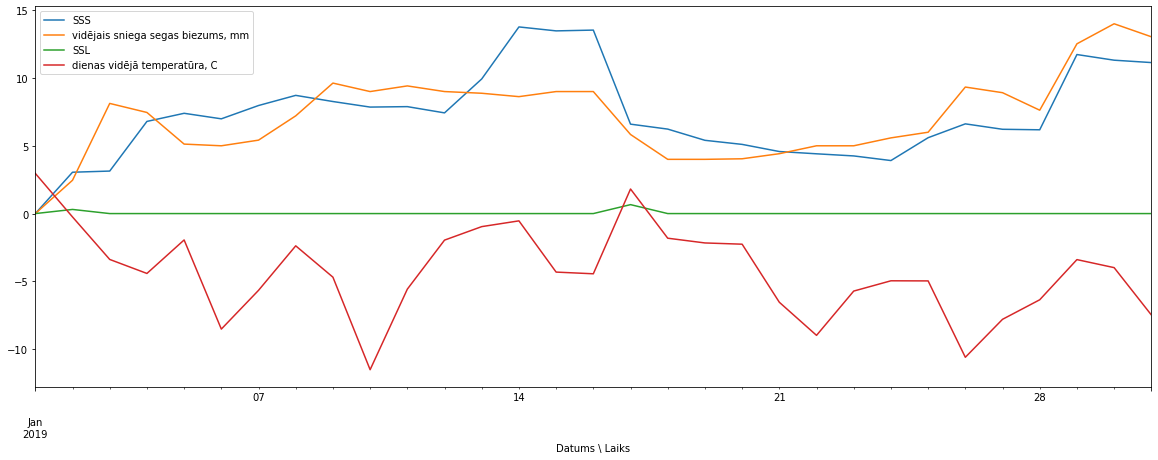

In [201]:
KS=1
T1=0.5
T2=-0.5
CMELT=3
WHC=0.1
CFR=0.1

for i in range(1, len(df)):
    p=df.iloc[i]["summa"]
    t=df.iloc[i]["dienas vidējā temperatūra, C"]
    h=df.iloc[i]["mitruma deficīts"]
    SSS=df.iloc[i-1]["SSS"]
    SSL=df.iloc[i-1]["SSL"]

                                                          #KS,  T1,  T2,CMelt,WHC,CFR
    SSS,SSL,ev,RS,summa=snowmodel(t,  p, h,   SSS,  SSL,   KS, T1, T2, CMELT,  WHC, CFR)
    df.iloc[i, df.columns.get_loc('SSS')]=SSS
    df.iloc[i,df.columns.get_loc('SSL')]=SSL

    
#df[["SSS"]].plot()
menesis="2019-01"
df[menesis][["SSS","vidējais sniega segas biezums, mm", "SSL", "dienas vidējā temperatūra, C"]].plot(figsize=(20,7))
#df[menesis]["summa"].plot(kind="bar")
